# Read MR data from Siemens (R) MR scanner 

Data will be stored in *.dat format, which should be uploaded to the notebook. 

Enjoy!

Andreia S Gaspar @ IST/ISR May 2021


## Install **pyMapVBVD** package 

In [106]:
pip install pyMapVBVD

## Import mapvbvd and read file *.dat

In [107]:
import mapvbvd

twixObj = mapvbvd.mapVBVD('/content/meas_MID00724_FID23972_t1_se_sag_320.dat')

pymapVBVD version 0.4.1
Software version: VD


Scan 1/2, read all mdhs: 60.6MB [00:00, 466MB/s]                            
Scan 2/2, read all mdhs: 111MB [00:00, 3.43GB/s]                    


In [108]:
# twix image content
twixObj[1].image

***twix_map_obj***
File: /content/meas_MID00724_FID23972_t1_se_sag_320.dat
Software: vd
Number of acquisitions read 317
Data size is [640, 32,317,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]
Squeezed data size is [320,32,317] (['Col', 'Cha', 'Lin'])
NCol = 640
NCha = 32
NLin  = 317
NAve  = 1
NSli  = 1
NPar  = 1
NEco  = 1
NPhs  = 1
NRep  = 1
NSet  = 1
NSeg  = 1
NIda  = 1
NIdb  = 1
NIdc  = 1
NIdd  = 1
NIde  = 1

## Read Data 



In [109]:
from attrdict import AttrDict
data = twixObj[1].image['']
np.shape(data)
data_squeeze = np.squeeze(data)
np.shape(data_squeeze) # verify size


read data:  25%|██▍       | 78/317 [00:00<00:00, 779.42it/s]/usr/local/lib/python3.7/dist-packages/mapvbvd/twix_map_obj.py:755: RuntimeWarning: invalid value encountered in add
  raw = (raw[:, 0] + 1j * raw[:, 1]).reshape(readShape, order='F')


(320, 32, 317)

Permute data for correct format 

In [111]:
# Data Dimension
NCha = int(twixObj[1].image.NCha)
Nslice = int(twixObj[1].image.NSli)
Nro = int(twixObj[1].image.NCol/2) # due to oversampling 
Nline = int(twixObj[1].image.NLin)

print('Number of Lines:', Nline)
print('Number of readout points:', Nro)
print('Number of coils:', NCha)

# permute coil dimention to last 
if NSli ==1:
  kspace =  np.moveaxis(data_squeeze, [0, 1, 2], [0, 2, 1])
else: 
  kspace =  np.moveaxis(data_squeeze, [0, 1, 2, 3], [0, 2, 3, 1])
 

Number of Lines: 317
Number of readout points: 320
Number of coils: 32


Text(0.5, 1.0, 'k-space coil #1')

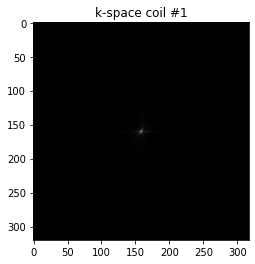

In [112]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

plt.figure(1)
# plt.subplot(121)
plt.imshow(np.absolute(kspace[:,:,0])) 
plt.gray()
plt.title('k-space coil #1')

# Reconstruction with iFFT transform from k-space to space domain

In [113]:
# iFFT transform from k-space to space domain

# initialize image variable
imspace = np.zeros((Nro, Nline, Nslice, NCha),dtype=complex)

if NSli ==1:
  sl = 0
  for ch in range(NCha):
    imspace[:,:,sl,ch] = np.fft.fftshift(np.fft.ifft2(kspace[:,:,ch]))
else: 
    for ch in range(NCha):
      for sl in range(Nslice):
        imspace[:,:,sl,ch] = np.fft.fftshift(np.fft.ifft2(kspace[:,:,sl,ch]))

# verify dimensions
imspace_squeeze = np.squeeze(imspace)
np.shape(imspace_squeeze)

(320, 317, 32)

In [140]:
# coil combine 'sum_squares':
images = np.sum(np.square(np.absolute(imspace)),axis=-1)

np.shape(images) # final image size

(320, 317, 1)

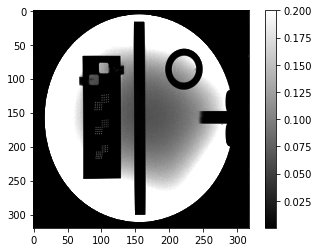

In [141]:
image_norm = np.divide(np.squeeze(images),np.max(np.squeeze(images)))
plt.figure(1)
plt.imshow(np.absolute(image_norm), vmax=0.2) 
plt.gray()
plt.colorbar()
